# Question 3 - very large notebook

## Overview

* I started this analysis by screening the data. Seeing that there were 357 variables for 3270 observations, I realised that there would not be enough data to perform a clustering analysis with the raw variables, therefore some dimension reduction was in order.
* Doing dimension reduction with the Likert scale questions should be relatively straightforward (for example, this is generally the response type used for exploratory factor analysis); however, the large number of binary responses coming from the multiple-choice questions would be much more challenging to work with. I wanted to see whether it would be possible to reduce the number of these used in the dimension reduction step by using the variables representing linear combinations of these variables instead.
* I saw that not all of the binary multiple-choice questions seemed to belong to a linear combination. I decided that the best way forward would be to use the linear combinations of the multiple choice variables, but also keep those binary variables which had a very weak relationship with the linear combinations (under the assumption that they were not part of any linear combination and therefore would contribute unique information to the model).
* I realised I now needed to do a dimension reduction with a mixture of continuous and categorical variables. My first attempt was therefore using Factor Analysis of Mixed Data (FAMD), which is designed to handle such data. However, the loadings were very unbalanced in this model, with ~70% of variance loading on the first component and then < 1% of variance on every component thereafter. Such a skewed loading might make it difficult for a clustering algorithm to tell apart the players.
* My second attempt at dimension reduction involved discarding all of the binary variables, converting all remaining variables to continuous, and performing PCA. (Being aware that this is not really a correct treatment of rank or count variables as they don't have an underlying continuous structure.) This attempt lead to a very spread out loading, with only 11% in the first component and 6% in the second. We also lost all responses from groups `F` and `N`.
* My final attempt at clustering was using exploratory factor analysis. I again used the same continuous dataset that I used for the PCA above. (Again, this was not done entirely correctly, as I used the default correlation matrix for FA which is not suitable for rank and count data.) This yielded a much nicer looking 14-factor structure; however, none of the variables from groups D, K or L loaded onto a factor. As such, I dropped these variables and built a new 11-factor structure.
* I then tried out these three reduced datasets as the inputs for a k-means cluster analysis. Unsurprisingly, the EFA had worked the best, with a fair higher average silhouette score in the cluster analysis than either the FAMD or PCA solutions.
* When testing with a range of possible means from 2 to 10, the silhouette plots suggested that a 2 cluster solution was the best, with an average silhouette score of 0.54 and two quite evenly distributed clusters (cluster 0 = 1915, 59%; cluster 1 = 1355, 41%). Apart from being the best from a model fit point-of-view, a lower number of clusters may be more manageable from a business/product perspective, if we are considering making personalised experiences for these players.
* A quick interpretation of the data showed that players in cluster 0 tended to be higher in `I_8`, but lower in `A_3`, `J_6`, `J_5` and `A_0`. Without labels on the data it is a little difficult to infer more about the groups.
* As this was a quick first-pass analysis, I have a few suggestions for future directions that might improve this solution:
    * Find a way to preserve the lost multiple-choice questions. A lot of data were lost because of the way I approached the dimension reduction and clustering, and it would ideal to be able to keep the information provided by those variables. An additional challenge in this is how skewed a lot of the binary responses are (most have 5% or less of respondants selecting `1`).
    * If the EFA is again selected as the dimension reduction technique, it should be performed with a polychoric correlation to properly account for the non-continuous nature of some of the variables used.
    * If the k-means clustering is retained as the clustering solution, it should be run multiple times in order to makes sure that poor initial centroid choices made by the model are not leading to a sub-optimal model fit.

## Data screening

In [1]:
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.cm as cm
import prince

from plotnine import *
from plotnine import ggplot
from scipy.stats import chi2_contingency, spearmanr, mannwhitneyu
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from cluster_challenge_functions import *

### Reading in and inspecting data dimensions

The data were read in. The table above lists 4 data types: binary (raw multiple choice questions), count (linear combinations of multiple choice questions), ordinal (rank variables) and Likert scales. The first three variable types should generally be treated as categorical types; however, Likert scales can be treated as either categorical or continuous (given that what we are attempting to measure is a continuous distribution of preferences between the upper and lower bounds of the scale, but we can only measure this using a discrete scale). For this analysis I will treat them as continuous.

In [3]:
dtypes_map = {}
cont_var_names = list()
cat_var_names = list()

# Get column names
with open("data/clustering_data.csv") as f:
    var_names = f.readline()

var_names = var_names.strip().split(",")

for col in var_names:
    if col.startswith(("A", "C", "E", "G", "H", "I", "J", "O", "P")):
        dtypes_map[col] = "float64"
        cont_var_names += [col]
    else:
        dtypes_map[col] = "category"
        cat_var_names += [col]

all_vars = pd.read_csv("data/clustering_data.csv", sep = ",", header = 0, dtype = dtypes_map)

In [3]:
all_vars.shape

(3270, 357)

The number of columns demonstrates that this is very high dimensional data, and it will not be possible to do a cluster analysis on the data in this form. As such, I will reduce down these data using a dimension reduction technique. However, first the data need to be inspected.

### Inspecting the distribution of categorical and continuous variables

The distribution of the variables was inspected. Firstly, the number of levels in the variables was checked.

/Users/jodieburchell/Documents/12traits-tech-test/.venv/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 55'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


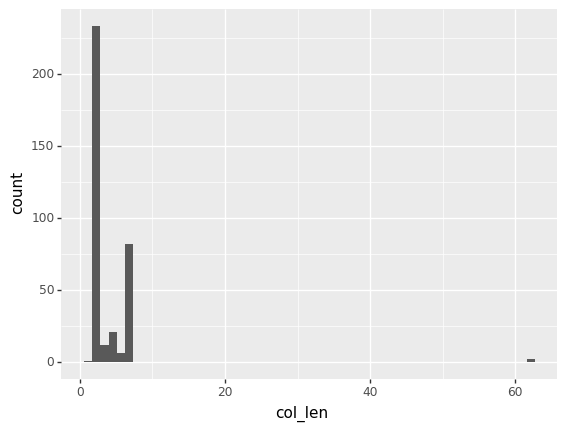

<ggplot: (311453361)>

In [4]:
col_len = list()
for col in var_names:
    col_len += [all_vars[col].value_counts().count()]

col_len_df = pd.DataFrame({
    "col_name": var_names,
    "col_len": col_len})

ggplot(col_len_df, aes("col_len")) + geom_histogram()

It can be seen that a small number of variables have more than seven levels, and at least one variable appears to only have one level.

In [5]:
col_len_df[col_len_df["col_len"] > 7]

,col_name,col_len
3,A_3,62
135,I_18,62


In [6]:
col_len_df[col_len_df["col_len"] < 2]

,col_name,col_len
340,N_7,1


`A_3` and `I_18` are labelled as Likert scales, so will be treated as such even though they are continuous (given that the Likert scales are being treated as continuous anyway). As `N_7` has no variance, it will need to be discarded.

### Check distribution of variables

Next, I checked the distribution of the variables in the dataset. It is important for both dimension reduction and the cluster analysis that variables have sufficient variance, so this needs to be checked before starting the analysis. Firstly, the proportion of 1's in the binary variables was looked at.

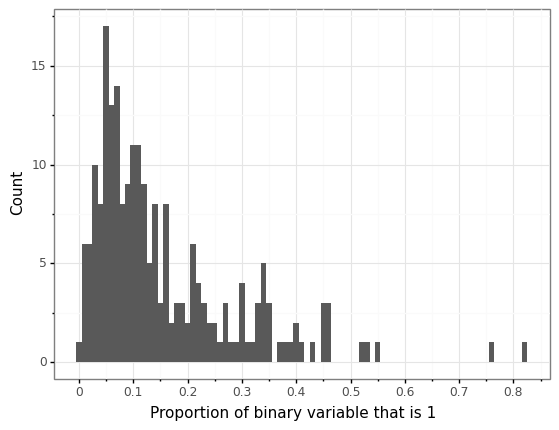

<ggplot: (310578605)>

In [7]:
binary_vars = \
    [f"D_{i}" for i in np.arange(0, 37)] + [f"F_{i}" for i in np.arange(0, 19)] +\
    [f"K_{i}" for i in np.arange(0, 66)] + [f"L_{i}" for i in np.arange(0, 48)] +\
    [f"M_{i}" for i in np.arange(0, 31)] + [f"N_{i}" for i in np.arange(0, 14)]

prop_1s = pd.DataFrame(all_vars[binary_vars].apply(lambda x: sum(x.astype(int)), axis=0),
                      columns = ["num_1s"])
prop_1s["prop_1s"] = prop_1s["num_1s"] / len(all_vars)

(
    ggplot(prop_1s, aes("prop_1s")) 
    + geom_histogram(binwidth = 0.01)
    + scale_x_continuous(breaks = np.arange(0, 1.1, 0.1))
    + xlab("Proportion of binary variable that is 1")
    + ylab("Count")
    + theme_bw()
)

It can be seen from the above chart that quite a lot of the binary variables are very skewed, with a sizeable number only having 5% or less `1` responses. This might be an issue for the dimension reduction step.

Next, the distributions of the continuous (Likert) and rank variables were inspected.

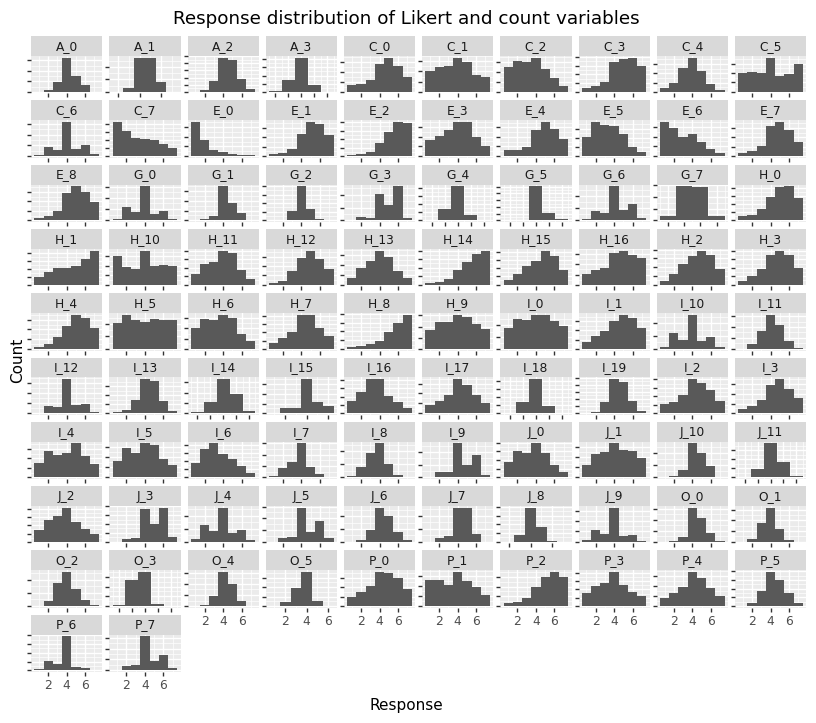

<ggplot: (310609033)>

In [8]:
# Check histograms of each of the Likert scales
cont_vars = all_vars[cont_var_names].unstack().reset_index()
cont_vars.columns = ["var_name", "index", "value"]

(
    ggplot(cont_vars, aes("value")) 
    + geom_histogram(binwidth = 1) 
    + ggtitle("Response distribution of Likert and count variables")
    + ylab("Count")
    + xlab("Response")
    + facet_wrap("~var_name", nrow = 10, ncol = 10, scales = "free")
    + theme(axis_text_y=element_blank(),
           figure_size=(10, 8))
)

All of the variables appeared to have fairly decent variance.

Similarly, the distributions of the linear combinations of multiple choice questions were also inspected.

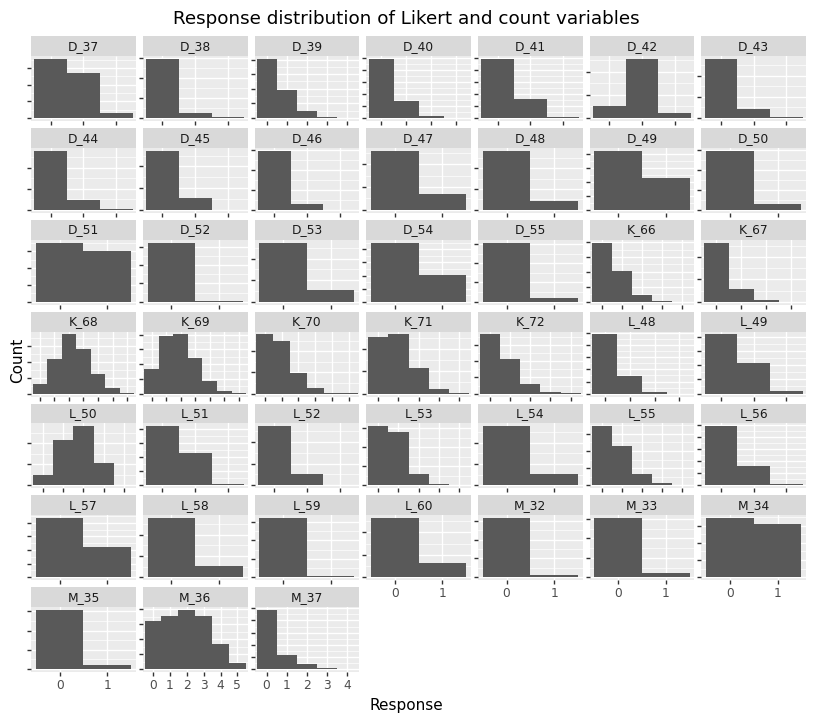

<ggplot: (316572873)>

In [9]:
linear_combos = \
    [f"D_{i}" for i in np.arange(37, 56)] + [f"K_{i}" for i in np.arange(66, 73)] + \
    [f"L_{i}" for i in np.arange(48, 61)] + [f"M_{i}" for i in np.arange(32, 38)]

linear_combo_vars = all_vars[linear_combos].unstack().reset_index()
linear_combo_vars.columns = ["var_name", "index", "value"]

(
    ggplot(linear_combo_vars, aes("value")) 
    + geom_histogram(binwidth = 1) 
    + ggtitle("Response distribution of Likert and count variables")
    + ylab("Count")
    + xlab("Response")
    + facet_wrap("~var_name", nrow = 7, ncol = 7, scales = "free")
    + theme(axis_text_y=element_blank(),
           figure_size=(10, 8))
)

In this case, there are a couple of these linear combinations which seem quite skewed.

### Relationships between categorical variables

In order to investigate the degree of relatedness between each of the categorical variables (features and outcome), the Chi-squared test of independence was run pairwise between each of these variables. As both the Chi-square and p-value metrics are unbounded (and as p-values can become extremely small in larger samples, such as this dataset), Cramer's V was primarily used as a bounded, and much more interpretable measure of the degree of relation between each of the variables. However, the p-values were also produced as a sanity check that the relationship between the variables is significant.

As calculating these pairwise relationships between such a large number of variables takes some time, this functionality was written in an external script to this notebook (`get_correlations.py`) and the results written to file. This file will be read in below.

In [10]:
cramers_v_df = pd.read_csv("data/categorical_relations.csv", sep = ";", header = 0)
cramers_v_df.columns = ["var_1", "var_2", "cramers_v", "sig"]

cramers_v_df.sort_values("cramers_v", ascending = False).head(10)

,var_1,var_2,cramers_v,sig
1612,D_10,D_51,0.999385,0.0
2377,D_13,D_49,0.999331,0.0
29141,L_12,L_57,0.999315,0.0
5122,D_23,D_54,0.999284,0.0
11120,D_47,D_9,0.999082,0.0
30170,L_21,L_60,0.999028,0.0
6326,D_28,D_53,0.998862,0.0
30260,L_22,L_54,0.998840,0.0
29667,L_17,L_58,0.998825,0.0
9336,D_4,D_48,0.998663,0.0


Unsurprisingly, the top relations between the categorical variables are between the linear combinations of multiple choice questions and their likely component questions. In order to see if other promising relationships exist between the categorical variables, I will remove the linear combinations from the dataset and inspect the data again.

In [11]:
cramers_v_raw_df = cramers_v_df[~(cramers_v_df["var_1"].isin(linear_combos)) &
                                ~(cramers_v_df["var_2"].isin(linear_combos))]

cramers_v_raw_df.sort_values("cramers_v", ascending = False).head(10)

,var_1,var_2,cramers_v,sig
1,B_0,B_3,0.380124,2.786664e-301
526,B_2,B_3,0.365171,1.101415e-277
0,B_0,B_2,0.360384,2.479134e-270
263,B_1,B_2,0.350798,6.637803e-256
264,B_1,B_3,0.348630,1.072322e-252
11765,D_5,D_6,0.323383,1.519520e-76
4358,D_20,D_28,0.317866,5.018103e-74
14677,F_10,N_9,0.281712,1.380826e-58
33719,M_1,M_24,0.279856,7.632963e-58
33685,M_0,M_5,0.264788,5.394237e-52


Using the benchmark of a Cramer's V of 0.1 as low, 0.3 as medium and 0.5 as a high relationship, it appears that there are some moderate relations between the binary variables, but nothing particularly high. This again could be an issue when performing the dimension reduction. In order to see whether the linear combinations tended to be more related than their component parts, the same inspection was done with all of the binary variables removed.

In [12]:
cramers_v_linear_df = cramers_v_df[~(cramers_v_df["var_1"].isin(binary_vars)) &
                                ~(cramers_v_df["var_2"].isin(binary_vars))]

cramers_v_linear_df.sort_values("cramers_v", ascending = False).head(10)

,var_1,var_2,cramers_v,sig
34704,M_34,M_36,0.697199,0.000000e+00
34682,M_33,M_37,0.435219,1.475558e-133
1,B_0,B_3,0.380124,2.786664e-301
526,B_2,B_3,0.365171,1.101415e-277
0,B_0,B_2,0.360384,2.479134e-270
263,B_1,B_2,0.350798,6.637803e-256
264,B_1,B_3,0.348630,1.072322e-252
10457,D_44,D_53,0.263360,2.143545e-50
34681,M_33,M_36,0.241395,2.617707e-40
34726,M_35,M_36,0.201971,4.009942e-28


There are a number of higher relations here, although again generally moderate to low.

### Relationship between continuous variables

As many of the continuous variables were skewed, I decided to use the non-parametric Mann-Whitney U-test to assess the relationships between each continuous features. Again, calculating this was time-consuming and was done in the separate script `get_correlations.py`, and then written to file.

In [13]:
spearman_r_df = pd.read_csv("data/continuous_relations.csv", sep = ";", header = 0)
spearman_r_df.columns = ["var_1", "var_2", "spearmans_r", "sig"]

spearman_r_df.sort_values("spearmans_r", ascending = False).head(10)

,var_1,var_2,spearmans_r,sig
234,A_2,I_19,1.000000,0.0
321,A_3,I_18,1.000000,0.0
3551,I_17,P_4,1.000000,0.0
3507,I_16,O_2,0.817171,0.0
844,C_5,J_4,0.815255,0.0
1911,G_3,H_0,0.794580,0.0
465,C_1,G_6,0.794349,0.0
2889,H_4,J_3,0.767098,0.0
2010,G_4,I_6,0.756643,0.0
3852,I_9,P_0,0.752468,0.0


Unlike the categorical variables, there were a number of very highly correlated continuous variables. There were also three perfectly correlated pairs, which is very suspicious ...

In [14]:
all_vars[["A_3", "I_18", "A_2", "I_19", "I_17", "P_4"]][:5]

,A_3,I_18,A_2,I_19,I_17,P_4
0,3.647059,3.647059,4.0,4.0,5.0,5.0
1,3.411765,3.411765,5.0,5.0,3.0,3.0
2,3.882353,3.882353,5.0,5.0,3.0,3.0
3,2.882353,2.882353,4.0,4.0,6.0,6.0
4,5.058824,5.058824,6.0,6.0,3.0,3.0


`A_3` and `I_18`, `A_2` and `1_19` and `I_17` and `P_4` seem to be completely identical pairs. As such, I'll just keep the first one of each pair, as keeping both may make dimension reduction more difficult.

### Relationship between each of the multiple-choice variables and their linear combinations

As it was not specified in the challenge outline which of the multiple choice questions make up each of the linear combinations, I decided to check the relationships within each of the groups.

<Figure size 720x504 with 0 Axes>

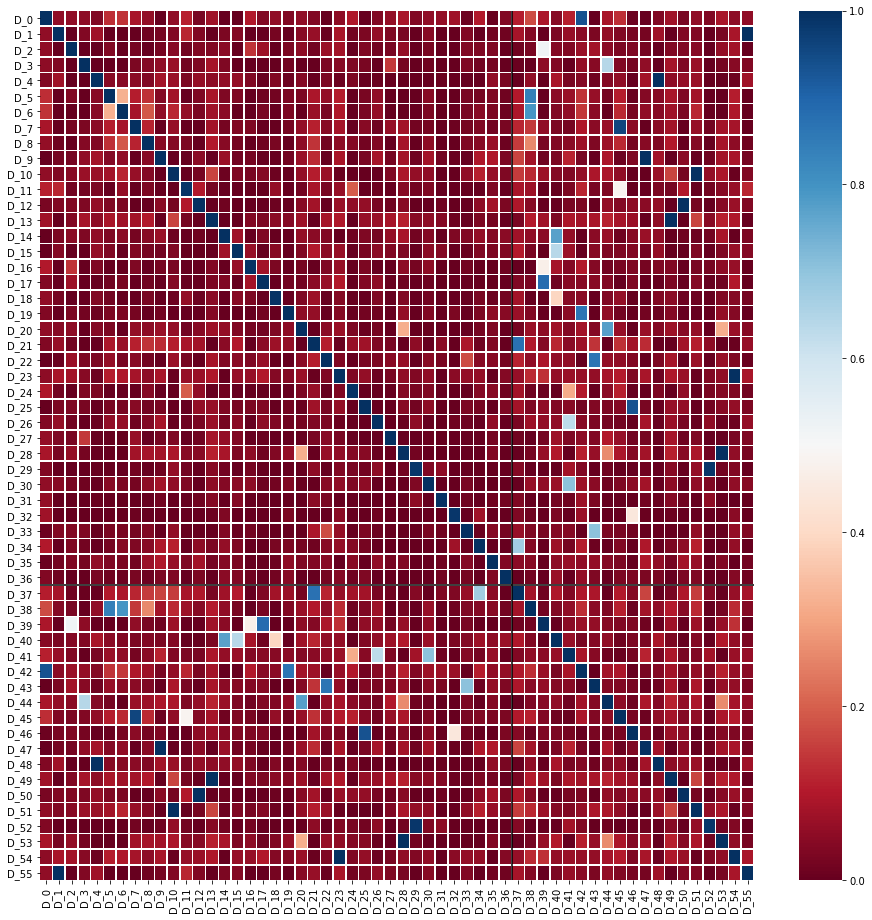

CPU times: user 35.9 s, sys: 169 ms, total: 36.1 s
Wall time: 36 s


In [15]:
%%time

cramers_v_matrix_by_group(all_vars, "D", 37)

<Figure size 720x504 with 0 Axes>

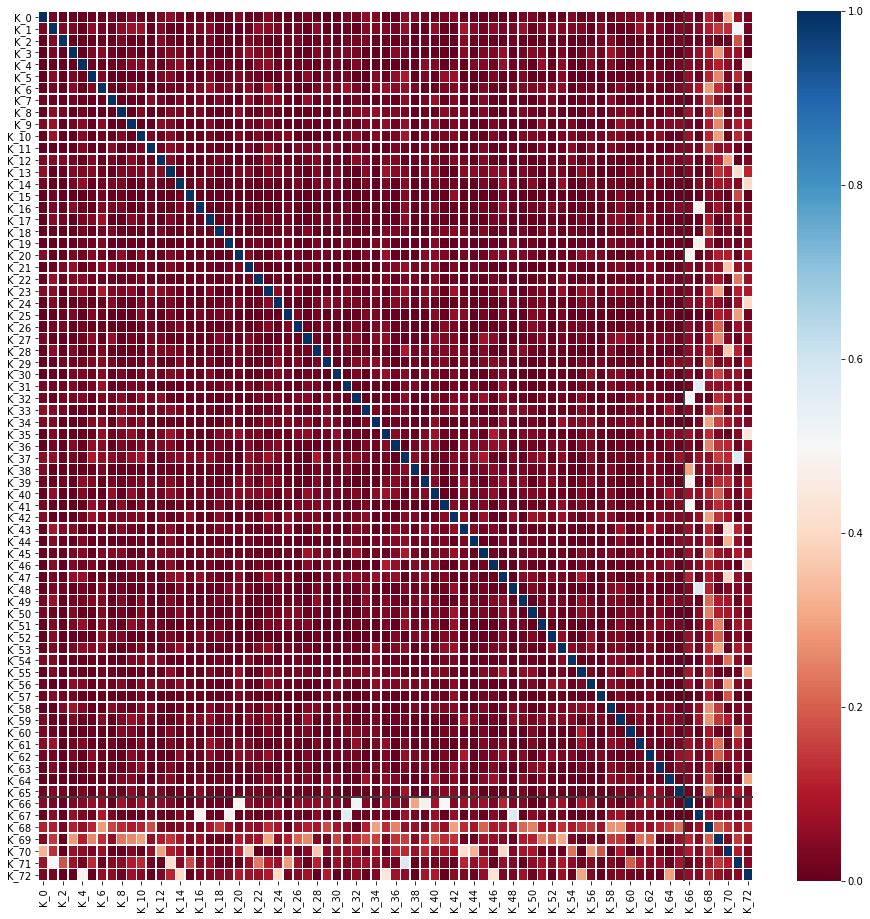

CPU times: user 1min, sys: 231 ms, total: 1min
Wall time: 1min


In [16]:
%%time

cramers_v_matrix_by_group(all_vars, "K", 66)

<Figure size 720x504 with 0 Axes>

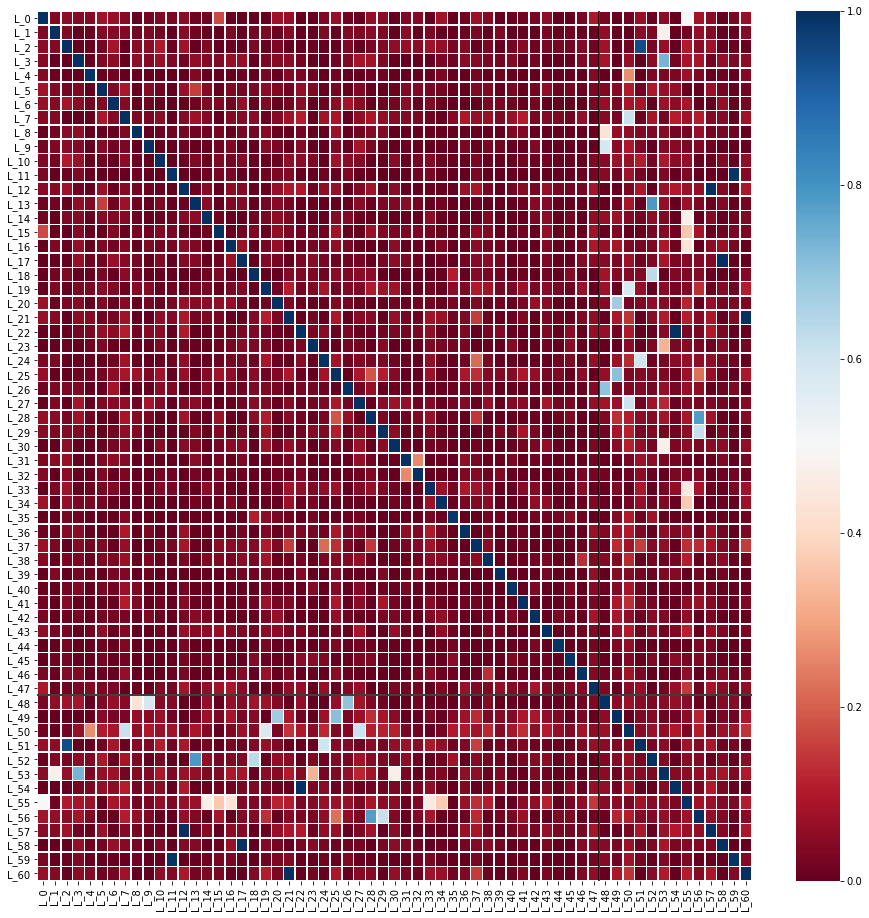

CPU times: user 42.8 s, sys: 228 ms, total: 43 s
Wall time: 42.9 s


In [17]:
%%time

cramers_v_matrix_by_group(all_vars, "L", 48)

<Figure size 720x504 with 0 Axes>

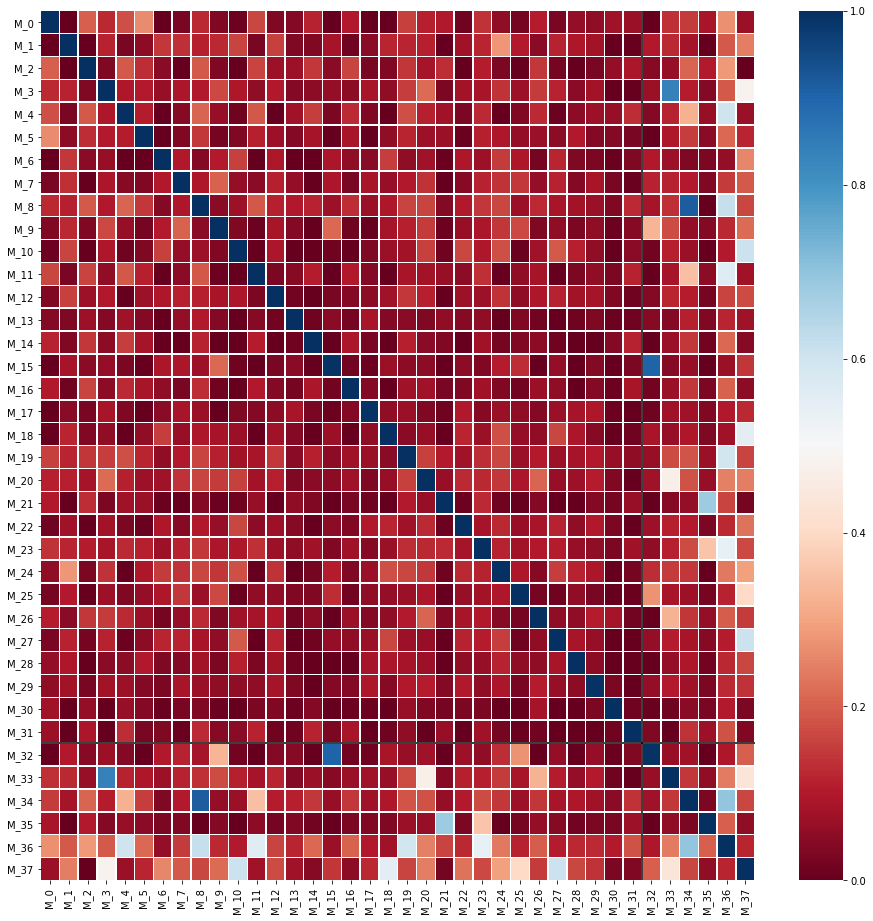

CPU times: user 15.9 s, sys: 85.3 ms, total: 16 s
Wall time: 15.8 s


In [18]:
%%time

cramers_v_matrix_by_group(all_vars, "M", 32)

As can be seen from these (massive!) heatmaps, there are a number of binary variables in each group that are clearly the components of the linear combinations. However, similarly, there are some that are not strongly related to any of the linear combinations. This suggests that perhaps the best strategy for capturing all of the variance represented by the multiple choice questions is by including the linear combinations as well as those binary variables which don't seem to form part of any of the linear combinations.

(As an aside, I tried just adding together all of the multiple choice questions for each group into a single linear combination, but this didn't work very well. Some of the groups had very little variance, and it seemed like a lot of information was being lost this way).

In order to do this, I just kept the linear combinations as well as those binary variables that didn't have a strong relationship with any of the linear combinations (as assessed by a Cramer's V of less than 0.1).

In [19]:
orphan_binary_vars = get_rel_binary_to_linear_combos(cramers_v_df, "D", 37, 56).append(
    get_rel_binary_to_linear_combos(cramers_v_df, "K", 66, 73))
orphan_binary_vars = orphan_binary_vars.append(
    get_rel_binary_to_linear_combos(cramers_v_df, "L", 48, 61))
orphan_binary_vars = orphan_binary_vars.append(
    get_rel_binary_to_linear_combos(cramers_v_df, "M", 32, 38))
orphan_binary_vars = orphan_binary_vars.loc[orphan_binary_vars["max_cramers_v"] < 0.1, "var_1"].\
                        to_list()

# Keep all continuous variables except those problematic ones identified earlier
vars_to_keep = [col for col in var_names if 
                col.startswith(("A", "C", "E", "G", "H", "I", "J", "O", "P", "B", "F", "N")) and
                col not in ["I_18", "I_19", "P_4", "N_7"]] +\
    linear_combos + orphan_binary_vars

### Data missingness

Finally, I also checked the overall missingness in the data and checked whether there are any issues with this.

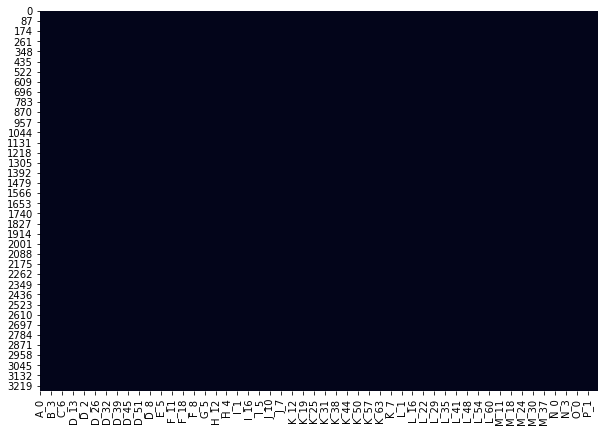

In [20]:
fig = plt.figure(figsize=(10,7))
ax = sns.heatmap(all_vars.isnull(), cbar=False)
plt.show()

In [21]:
total_missingness = all_vars.isnull().sum().sum() / all_vars.size
print(f"Total missingness of data in the sample = {total_missingness:.2%}")

Total missingness of data in the sample = 0.00%


Fortunately there is no missing data in this sample, meaning we can move onto the dimension reduction step.

## Dimension reduction

The initial approach used for the dimension reduction was Factor Analysis of Mixed Data (FAMD). This is an approach recommended when there is a combination of both categorical and continuous variables, and uses PCA for the continuous variables and MCA for the categorical variables (see [this article](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006907) for an example). The excellent [Prince package](https://github.com/MaxHalford/prince) has a very easy-to-use implementation of FAMD.

Amount of variance explained by top 5 loadings: [0.7082368534062088, 0.007125197996623969, 0.005847509180204213, 0.005211376577645971, 0.004767053653601829]

Minimum components to get to 80% explained: 25


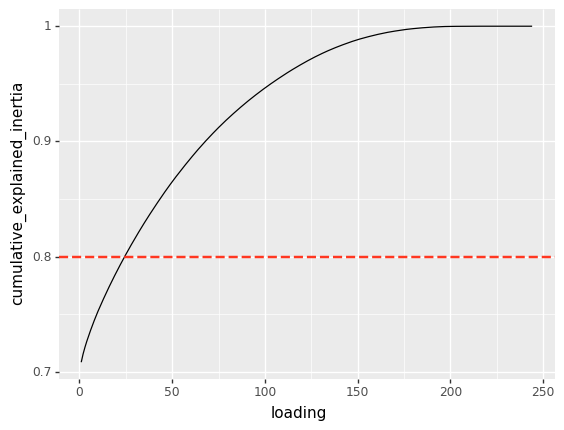

<ggplot: (312674949)>

In [22]:
subset_vars = all_vars[vars_to_keep]

famd = prince.FAMD(
    n_components = len(subset_vars.columns),
    n_iter = 5,
    copy = True,
    check_input = True,
    engine = 'auto',
    random_state = 42
)

assess_prince(famd, subset_vars)

Unfortunately, the loadings are very uneven. Most of the variance seems to be explained by the first variable, which may make it quite difficult for the cluster analysis to tell apart observations using these loadings. I tried also performing the FAMD with all of the binary variables removed, but it didn't make much difference.

As such, I tried something slightly cheeky. I again removed all of the binary variables from the dataset and transformed all of the remaining variables to numeric (the count, rank and Likert scales). I then performed a PCA on these variables.

Amount of variance explained by top 5 loadings: [0.11211139730254578, 0.06274538109534403, 0.04134700491932605, 0.036035918163261675, 0.0273228039059626]

Minimum components to get to 80% explained: 55


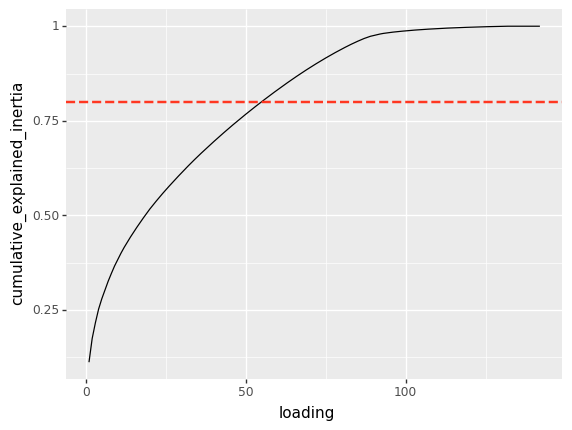

<ggplot: (277900265)>

In [23]:
no_binary_vars = all_vars.drop(columns = binary_vars)
no_binary_vars = no_binary_vars.astype(float)

pca = prince.PCA(
    n_components=len(no_binary_vars.columns),
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)

assess_prince(pca, no_binary_vars)

These loadings look more even, but are quite sparsely loaded. It will take 55 components to get to 80% of the variance covered!

Given that I already had a dataset where I was treating all of the variables as continuous, I decided to try a different approach to dimension reduction and perform an exploratory factor analysis. I considered this because it might be possible to capture the underlying structure of the variable groups that we already have in the dataset as latent factors rather than just trying to compress the data. Capturing these existing groups might be more meaningful for a cluster analysis. It would have been more correct to do the EFA with a polychoric correlation, but I couldn't work out how to do this in Python in the time I had, so I used the default Pearson correlation matrix.

To start, we confirm that the data have sufficient intercorrelation to perform the factor analysis using Bartlett’s test of sphericity, and also whether the data have sufficient variance using the Kaiser-Meyer-Olkin (KMO) Test. We inspecting these properties of the data as part of the data screening, but it is a good idea to confirm this statistically.

In [24]:
chi_square_value, p_value = calculate_bartlett_sphericity(no_binary_vars)
kmo_all, kmo_model = calculate_kmo(no_binary_vars)

print(f"Bartlett’s test of sphericity: {chi_square_value}, {p_value}")
print(f"Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")

Bartlett’s test of sphericity: 1510530.1480775562, 0.0
Kaiser-Meyer-Olkin (KMO) Test: 0.7206276772821009


/Users/jodieburchell/Documents/12traits-tech-test/.venv/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


The Bartlett’s test is significant, and the KMO value is above 0.6, indicating that our data are suitable for EFA.

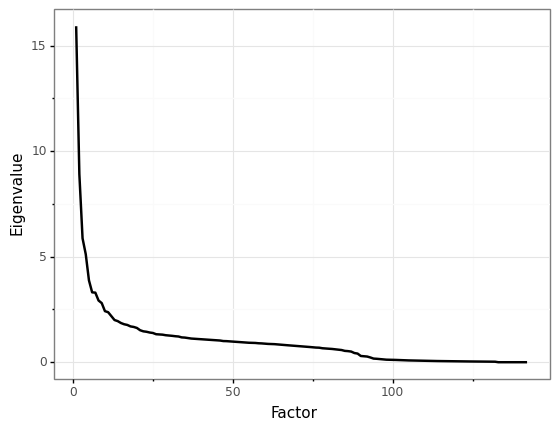

<ggplot: (316059017)>

In [25]:
fa = FactorAnalyzer()
fa.fit(no_binary_vars, 25)
eigen_values, vectors = fa.get_eigenvalues()

ev_df = pd.DataFrame({"factor": np.arange(1, len(eigen_values) + 1),
                      "eigenvalue": eigen_values})

(
    ggplot(ev_df, aes("factor", "eigenvalue")) 
    + geom_line(size = 1)
    + xlab("Factor")
    + ylab("Eigenvalue")
    + theme_bw()
)

An analysis of the eigenvalues demonstrates that 45 are above 1. It will therefore be easily possible to use 14 factors to represent the 14 groups in the data that are present in the current dataset. When I was screening the data I saw some relations between variables belonging to different groups. As such, I used a `promax` rotation rather than a `varimax` one, in order to loosen up the requirement of factor orthagonality.


Cumulative variance explained: 0.4253541240926041


<Figure size 720x504 with 0 Axes>

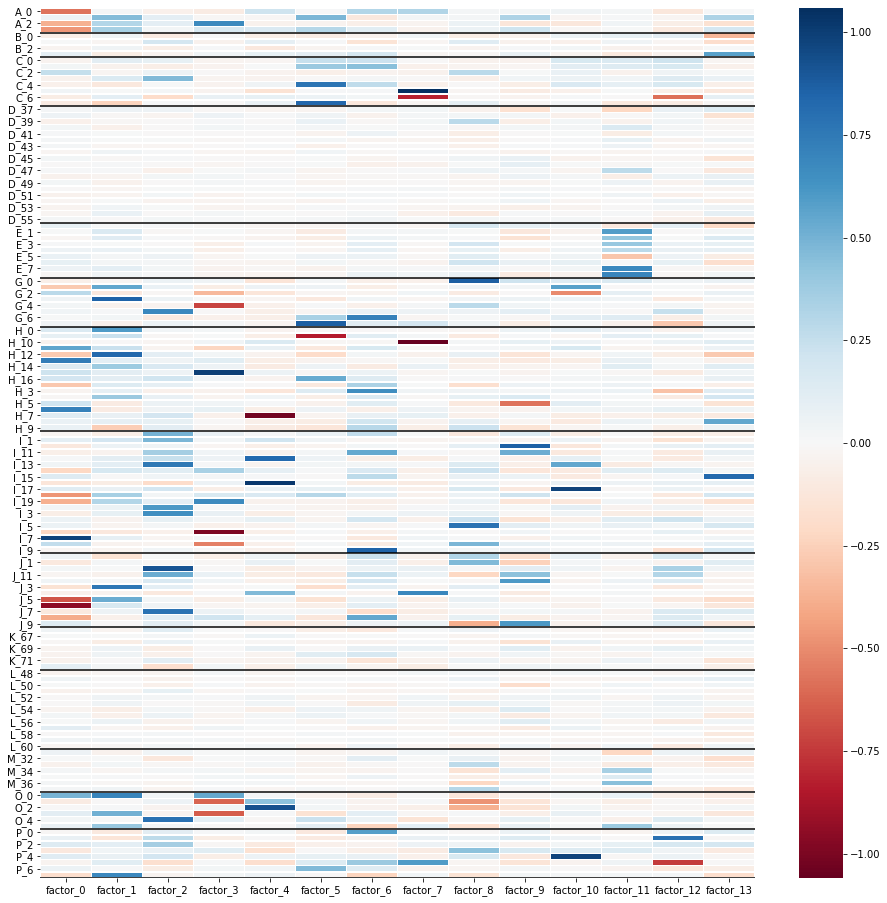

In [26]:
n_factors = 14

fa = FactorAnalyzer()
fa.set_params(n_factors=n_factors, rotation="promax")
fa.fit(no_binary_vars)
loadings = fa.loadings_

factor_loadings_df = pd.DataFrame(loadings, 
                                  index = no_binary_vars.columns, 
                                  columns = [f"factor_{i}" for i in np.arange(0, n_factors)])

print(f"\nCumulative variance explained: {fa.get_factor_variance()[2][-1]}")

fig = plt.figure(figsize=(10,7))
fig.suptitle("Cramer's V values from Chi-square test of independence", fontsize=15)
plt.figure(figsize=(16, 16))
ax = sns.heatmap(factor_loadings_df, linewidth=0.5, cmap = "RdBu")
ax.hlines([4, 8, 16, 35, 44, 52, 69, 89, 101, 108, 121, 128, 134, 142], *ax.get_xlim())
plt.show()

It seems that almost every group loads onto at least one factor, although their loadings do overlap. However, none of the variables from groups D, K or L loaded onto a factor. As such, I will remove them from the EFA and see whether I get better results.


Cumulative variance explained: 0.5158995075320681


<Figure size 720x504 with 0 Axes>

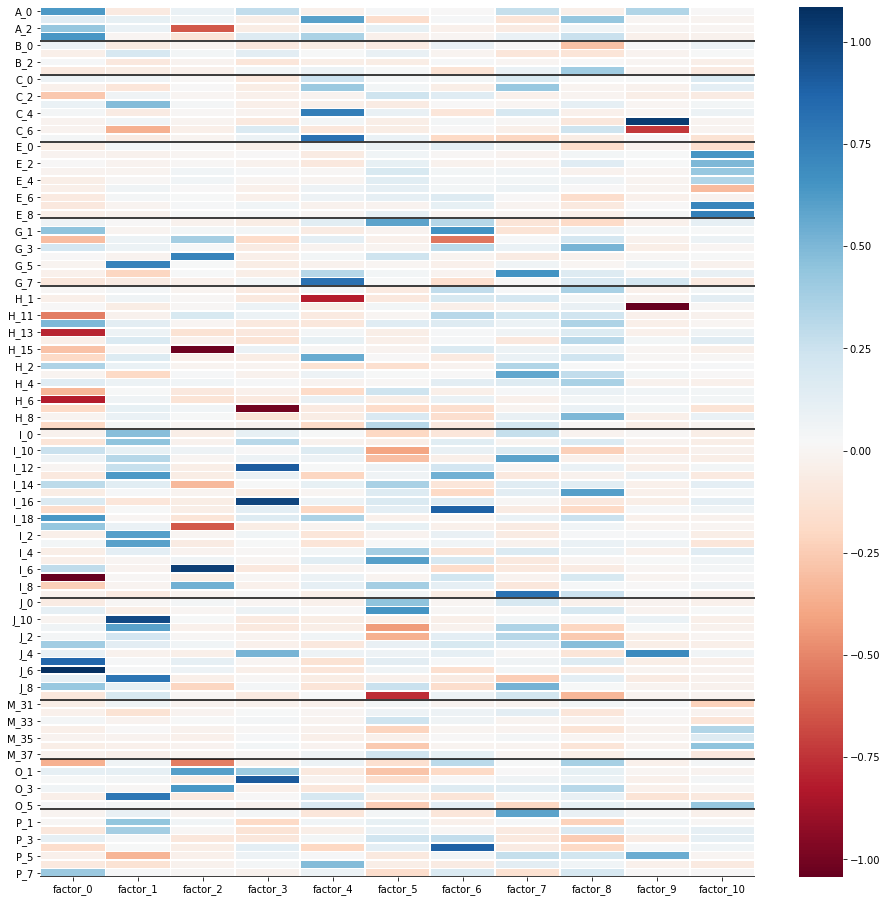

In [27]:
n_factors = 11

fa_bin_subset = no_binary_vars[[c for c in no_binary_vars.columns if not c.startswith(("D", "K", "L"))]]

fa = FactorAnalyzer()
fa.set_params(n_factors=n_factors, rotation="promax")
fa.fit(fa_bin_subset)
loadings = fa.loadings_

factor_loadings_df = pd.DataFrame(loadings, 
                                  index = fa_bin_subset.columns, 
                                  columns = [f"factor_{i}" for i in np.arange(0, n_factors)])

print(f"\nCumulative variance explained: {fa.get_factor_variance()[2][-1]}")

fig = plt.figure(figsize=(10,7))
fig.suptitle("Cramer's V values from Chi-square test of independence", fontsize=15)
plt.figure(figsize=(16, 16))
ax = sns.heatmap(factor_loadings_df, linewidth=0.5, cmap = "RdBu")
ax.hlines([4, 8, 16, 25, 33, 50, 70, 82, 89, 95, 103], *ax.get_xlim())
plt.show()

This certainly looks better, with all variables loading onto at least one factor and a higher proportion of variance explained by the model. If I had information about the variables in the dataset, it would also be possible to interpret the factors and check if the loadings made sense.

I now have three possible dimension reductions (the FAMD, the PCA and the 11 factor EFA). Although the EFA looks the most promising of the three, I will verify this with the cluster analysis to see which one gives the best separation of the groups.

In [28]:
famd = prince.FAMD(
    n_components = 25,
    n_iter = 5,
    copy = True,
    check_input = True,
    engine = 'auto',
    random_state = 42
)
famd.fit(subset_vars)
famd_reduced_vars = famd.transform(subset_vars)
famd_reduced_vars.columns = [f"component_{i}" for i in np.arange(0, 25)]

pca = prince.PCA(
    n_components = 55,
    n_iter = 3,
    rescale_with_mean = True,
    rescale_with_std = True,
    copy = True,
    check_input = True,
    engine = 'auto',
    random_state = 42
)
pca.fit(no_binary_vars)
pca_reduced_vars = pca.transform(no_binary_vars)
pca_reduced_vars.columns = [f"component_{i}" for i in np.arange(0, 55)]

efa_reduced_matrix = fa.transform(fa_bin_subset)
efa_reduced_vars = pd.DataFrame(efa_reduced_matrix, 
                                columns = [f"factor_{i}" for i in np.arange(0, 11)])

## Cluster analysis

For the cluster analysis, I decided to use K-means clustering for 2 reasons:
* The challenge guidelines suggests that choice of the number of clusters needs to take into account the business needs. K-means allows you to choose the number of clusters, meaning that both the technical and business requirements could be taken into account; and
* K-means tends to form tighter clusters than hierarchical clustering, which could be helpful when trying to trying to clearly differentiate groups of players.

In order to keep things simple, I did not attempt to pull the variables I removed during the dimension reduction stage back into the cluster analysis, as clustering with mixed categorical/continuous variables is a bit fiddly and I didn't have time to play around with this.

In [29]:
initial_kmeans = KMeans(n_clusters = 5, random_state = 10)

famd_cluster_labels = initial_kmeans.fit_predict(famd_reduced_vars)
famd_silhouette_avg = silhouette_score(famd_reduced_vars, famd_cluster_labels)
print(f"Average silhouette score for FAMD dimension reduction: {famd_silhouette_avg}")

pca_cluster_labels = initial_kmeans.fit_predict(pca_reduced_vars)
pca_silhouette_avg = silhouette_score(pca_reduced_vars, pca_cluster_labels)
print(f"Average silhouette score for PCA dimension reduction: {pca_silhouette_avg}")

efa_cluster_labels = initial_kmeans.fit_predict(efa_reduced_vars)
efa_silhouette_avg = silhouette_score(efa_reduced_vars, efa_cluster_labels)
print(f"Average silhouette score for EFA dimension reduction: {efa_silhouette_avg}")

Average silhouette score for FAMD dimension reduction: 0.039676399520459565
Average silhouette score for PCA dimension reduction: 0.040738965269692756
Average silhouette score for EFA dimension reduction: 0.48336623278477836


It seems clear from the intial average silhouette scores (using 5 clusters) that the EFA dimension reduction massively outperforms the FAMD and PCA dimension reductions. I'll therefore use that to try and determine the optimal number of clusters. As we are trying to use this for a business case we likely don't want to have too many, so the maximum number of clusters I'll look at is 10.

For n_clusters = 2 The average silhouette_score is : 0.5421597084490687
For n_clusters = 3 The average silhouette_score is : 0.4983988786158883
For n_clusters = 4 The average silhouette_score is : 0.4898241437979675
For n_clusters = 5 The average silhouette_score is : 0.48336623278477836
For n_clusters = 6 The average silhouette_score is : 0.45902647378115047
For n_clusters = 7 The average silhouette_score is : 0.4498288277574857
For n_clusters = 8 The average silhouette_score is : 0.43590304985539097
For n_clusters = 9 The average silhouette_score is : 0.42181051722281004
For n_clusters = 10 The average silhouette_score is : 0.41821454300557315


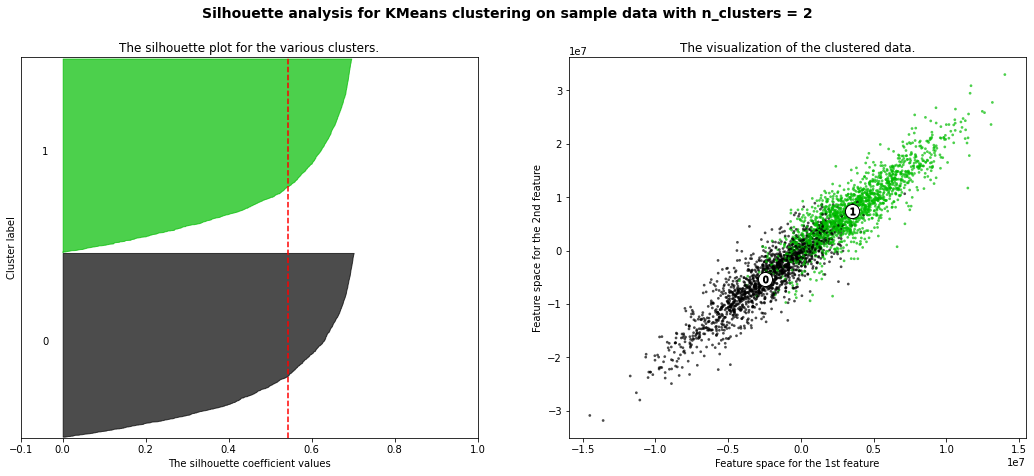

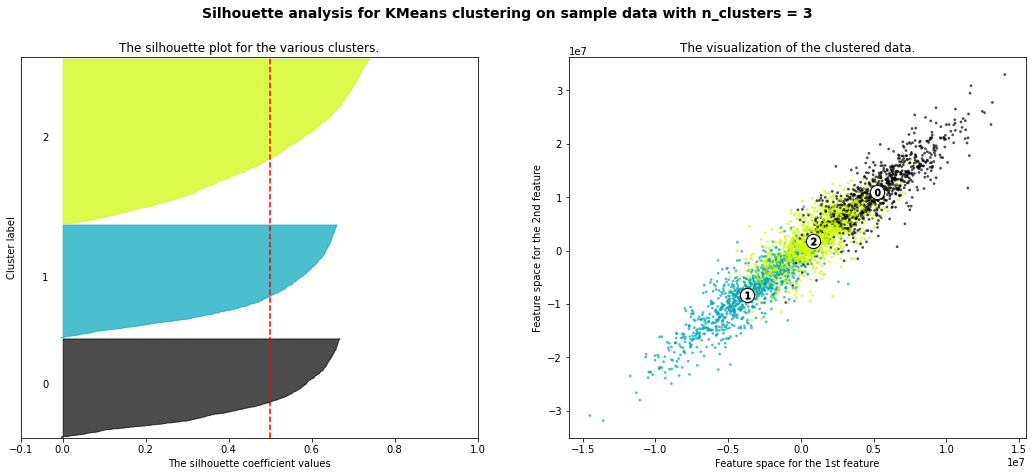

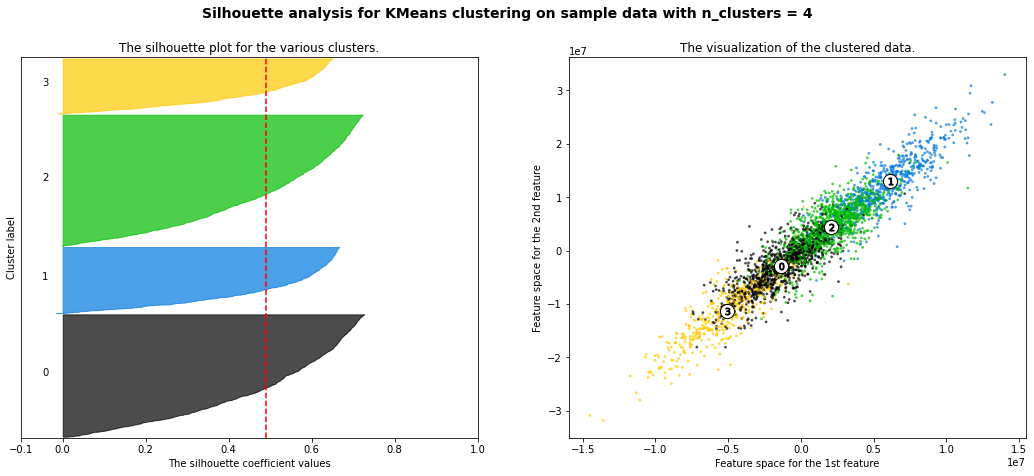

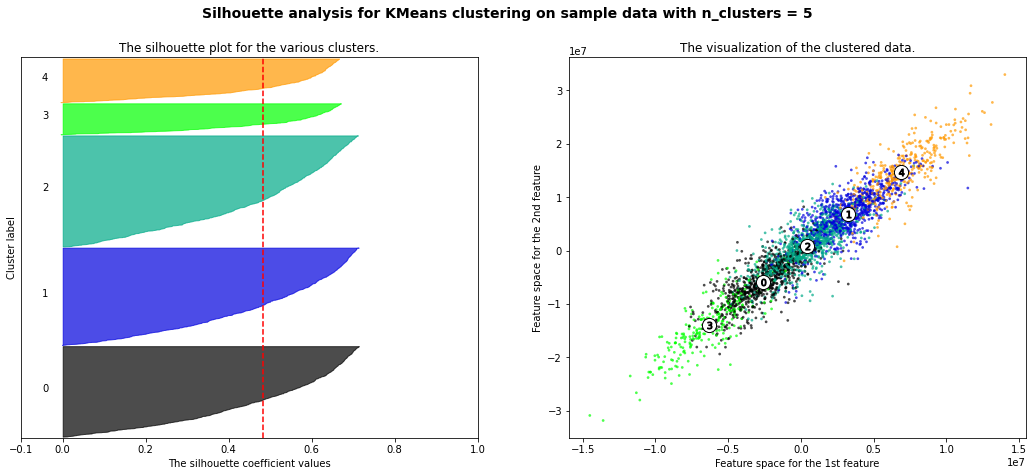

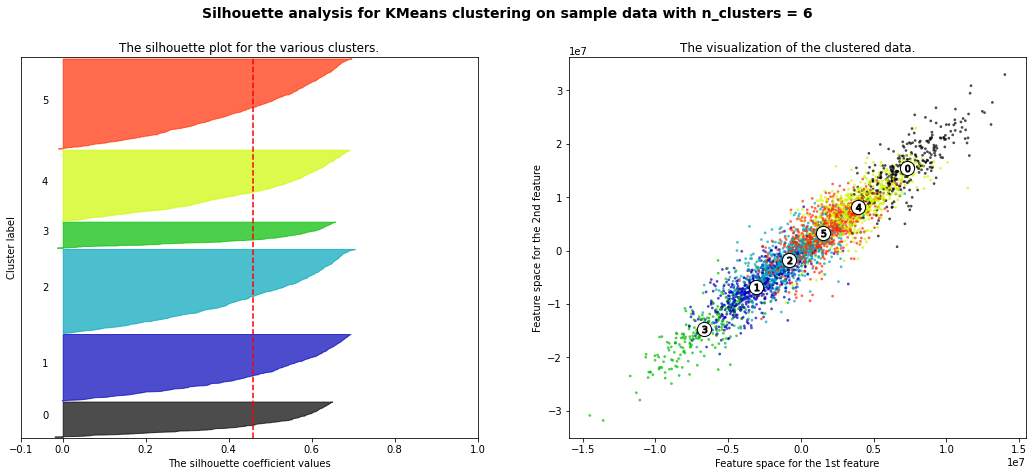

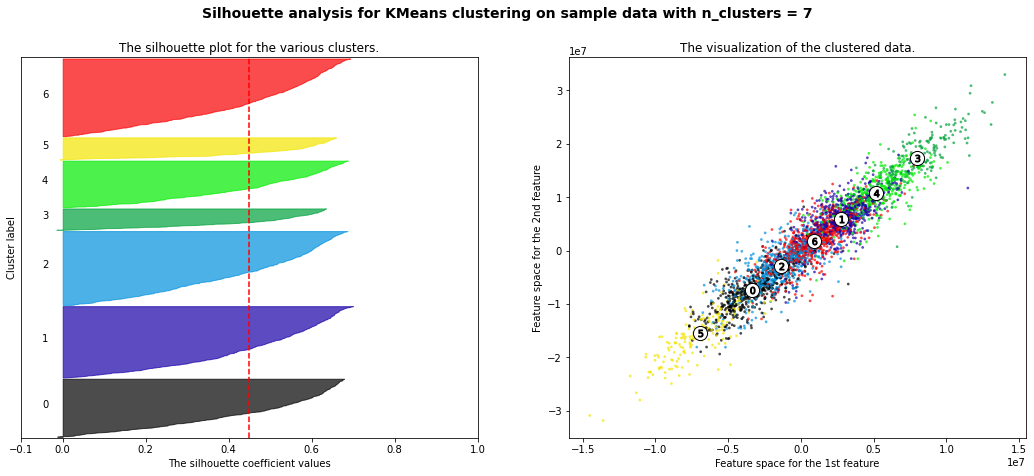

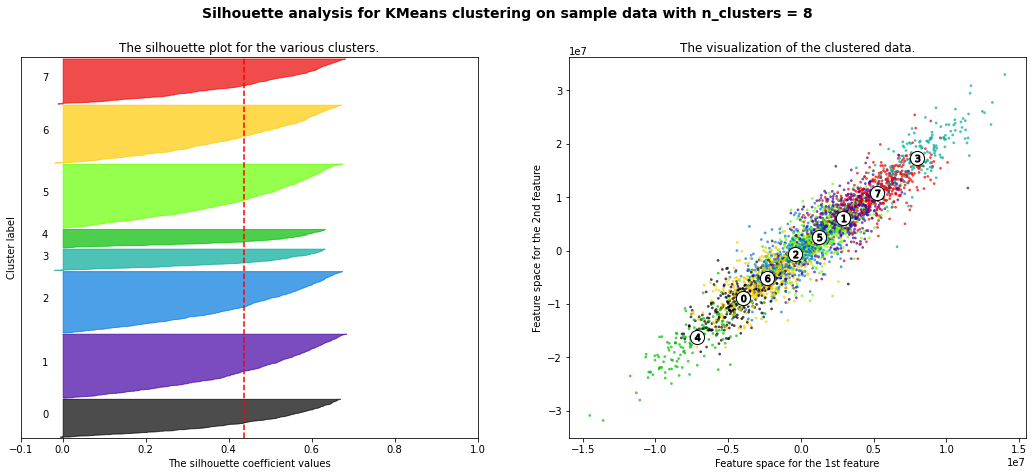

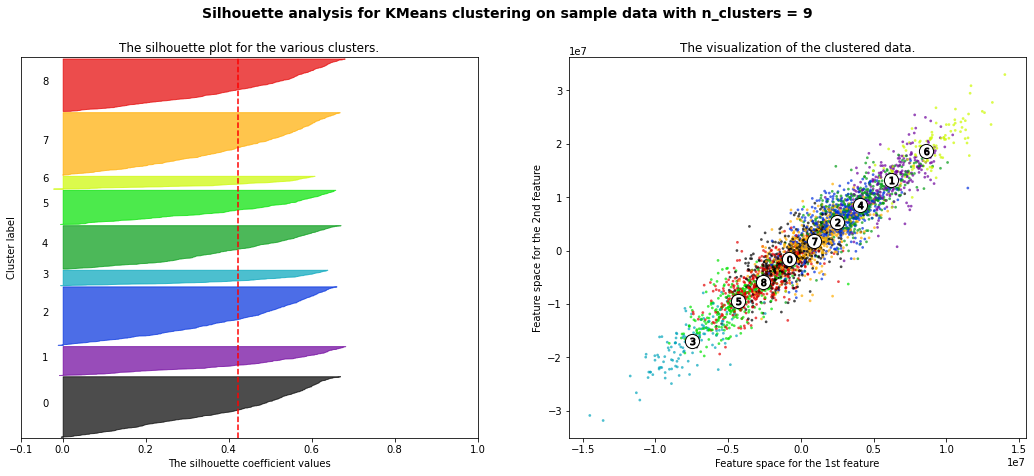

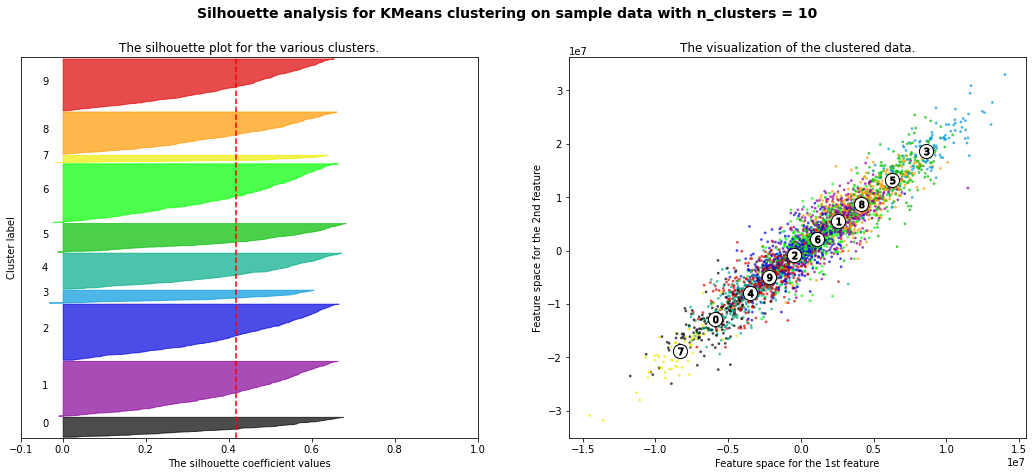

In [30]:
generate_silhouette_plots(efa_reduced_vars, 11)

The silhouette analysis clearly points to 2 clusters being the best solution, although it is possible that 3 could also provide a satisfactory solution. I will use 2 for my final grouping as it had both the highest silhouette score and the most even groups.

In [34]:
final_kmeans = KMeans(n_clusters = 2, random_state = 10)
final_cluster_labels = final_kmeans.fit_predict(fa_bin_subset)

fa_bin_subset["clusters"] = final_cluster_labels
get_value_counts(fa_bin_subset["clusters"])

/Users/jodieburchell/Documents/12traits-tech-test/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,frequency,proportion
1,1926,0.588991
0,1344,0.411009


## Interpreting the clusters

I order to get a sense of what the psychological profile of these groups might look like, I performed a Mann-Whitney U-test on each of the variables used in the cluster analysis to check which variables had the biggest difference between the two groups. If I had more information about the variables in this dataset, it could have been possible to also interpret the factors instead of individual variables.

In [35]:
u_value = list()
sig = list()

for v in list(fa_bin_subset.columns)[:-1]:
    u, p = mannwhitneyu(fa_bin_subset.loc[fa_bin_subset["clusters"] == 0, v],
                        fa_bin_subset.loc[fa_bin_subset["clusters"] == 1, v])
    u_value += [u]
    sig += [p]
    
cluster_diff_df = pd.DataFrame({
    "variable": list(fa_bin_subset.columns)[:-1],
    "u_value": u_value,
    "sig": sig
})

In [36]:
for v in list(cluster_diff_df.sort_values("u_value", ascending = True).head(5)["variable"]):
    print(fa_bin_subset[[v, "clusters"]].groupby("clusters").describe())

             A_3                                                              \
           count      mean       std       min       25%       50%       75%   
clusters                                                                       
0         1344.0  4.346113  0.404189  3.176471  4.058824  4.294118  4.602941   
1         1926.0  3.589579  0.385363  1.882353  3.352941  3.588235  3.882353   

                    
               max  
clusters            
0         5.705882  
1         4.705882  
             J_6                                             
           count      mean       std  min  25%  50%  75%  max
clusters                                                     
0         1344.0  5.110119  0.807496  3.0  5.0  5.0  6.0  7.0
1         1926.0  3.910177  0.746754  1.0  3.0  4.0  4.0  6.0
             J_5                                             
           count      mean       std  min  25%  50%  75%  max
clusters                                                    

As can be seen, the distribution of the groups was relatively even, with 1915 (59%) of players falling into cluster 0 and 1355 (41%) into cluster 1. Players in cluster 0 tended to be higher in `I_8`, but lower in `A_3`, `J_6`, `J_5` and `A_0`. Without labels on the data it is a little difficult to infer more about the groups.

## Future room for improvement

There were a number of issues I faced in this analysis:
* As mentioned above, using a Pearson correlation matrix in EFA with variables that are not strictly continuous (such as the rank variables) is not ideal. This analysis could be rerun with a polychoric correlation. 
* I had to drop a large number of the multiple choice questions as I was just not able to integrate them into my dimension reduction nicely. This is a massive loss of data, and should be addressed in a future redo of this analysis. It could be address through a better manual combination of the multiple choice questions, a dimension reduction technique that can better handle large numbers of (skewed) binary variables, or even in the clustering itself.
* The k-means clustering that I performed was just a first pass. It is possible that only running it once means that poor initial centroids were chosen by chance and that my solution is not optimal. Ideally k-means clustering would be run around 50-200 times and the solution with the lowest cost would the be retained model.
* The ok-but-not-great average silhouette score for the k-means clustering suggests that this clustering solution could definitely be improved: whether this is from a more sophisticated dimension reduction technique, use of the multiple choice questions that were dropped or some other technique remains to be seen.